# Style Transfer

<img src="https://i0.wp.com/chelseatroy.com/wp-content/uploads/2018/12/neural_style_transfer.png?resize=768%2C311&ssl=1">

La idea de este trabajo final es reproducir el siguiente paper:

https://arxiv.org/pdf/1508.06576.pdf

El objetivo es transferir el estilo de una imagen dada a otra imagen distinta. 

Como hemos visto en clase, las primeras capas de una red convolucional se activan ante la presencia de ciertos patrones vinculados a detalles muy pequeños.

A medida que avanzamos en las distintas capas de una red neuronal convolucional, los filtros se van activando a medida que detectan patrones de formas cada vez mas complejos.

Lo que propone este paper es asignarle a la activación de las primeras capas de una red neuronal convolucional (por ejemplo VGG19) la definición del estilo y a la activación de las últimas capas de la red neuronal convolucional, la definición del contenido.

La idea de este paper es, a partir de dos imágenes (una que aporte el estilo y otra que aporte el contenido) analizar cómo es la activación de las primeras capas para la imagen que aporta el estilo y cómo es la activación de las últimas capas de la red convolucional para la imagen que aporta el contenido. A partir de esto se intentará sintetizar una imagen que active los filtros de las primeras capas que se activaron con la imagen que aporta el estilo y los filtros de las últimas capas que se activaron con la imagen que aporta el contenido.

A este procedimiento se lo denomina neural style transfer.

# En este trabajo se deberá leer el paper mencionado y en base a ello, entender la implementación que se muestra a continuación y contestar preguntas sobre la misma.

# Una metodología posible es hacer una lectura rápida del paper (aunque esto signifique no entender algunos detalles del mismo) y luego ir analizando el código y respondiendo las preguntas. A medida que se planteen las preguntas, volviendo a leer secciones específicas del paper terminará de entender los detalles que pudieran haber quedado pendientes.

Lo primero que haremos es cargar dos imágenes, una que aporte el estilo y otra que aporte el contenido. A tal fin utilizaremos imágenes disponibles en la web.

##Videos
Paper explicado
https://www.youtube.com/watch?v=0tTRA3emrr4

Implementación del paper
https://www.youtube.com/watch?v=K_xBhp1YsrE

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Imagen para estilo
#!wget https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg

# Imagen para contenido
#!wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg

# Creamos el directorio para los archivos de salida
#!mkdir /content/drive/MyDrive/Colab Notebooks/TP Final - Style Transfer/output


In [4]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg19
from keras import backend as K
from pathlib import Path

Using TensorFlow backend.


In [5]:
# Definimos las imagenes que vamos a utilizar, y el directorio de salida

base_image_path = Path("/content/drive/MyDrive/Colab Notebooks/TP Final - Style Transfer/vermeer.jpg")
style_reference_image_path = Path("/content/drive/MyDrive/Colab Notebooks/TP Final - Style Transfer/klimt.jpg")
result_prefix = Path("/content/drive/MyDrive/Colab Notebooks/TP Final - Style Transfer/Punto9")
iterations = 100

# 1) En base a lo visto en el paper ¿Qué significan los parámetros definidos en la siguiente celda?

Respuesta:

La fórmula total de la Loss se compone de 2 partes:

$\mathcal{L}_{total}(\vec{p},\vec{a},\vec{x})=\alpha.\mathcal{L}_{content}(\vec{p}, \vec{x}) + \beta.\mathcal{L}_{style}(\vec{a}, \vec{x})$

La primera parte está vinculada con el contenido y la segunda con el estilo. A través de los factores $\alpha$ (content weight) y $\beta$ (style weight) se puede calibrar quien tiene mayor predominancia en el resultado final. Si se quiere dar mayor importancia al contenido tiene que aumentar la relación de $\alpha$/$\beta$. En caso de que se desee dar más protagonismo al estilo esta relación debe disminuir.

El total_variation_weight es utilizado para pesar la Total Variation Loss. Este parámetro permite calibrar con que suavidad se reconstruye la imagen combinada.

In [6]:
total_variation_weight = 1#0.1
style_weight = 10#10
content_weight = 1#1

In [7]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

#Se transforma la imagen base (content) de un tamaño de 775x599 a 517x400 manteniendo la misma relación de aspecto

# 2) Explicar qué hace la siguiente celda. En especial las últimas dos líneas de la función antes del return. ¿Por qué?

Ayuda: https://keras.io/applications/

Respuesta:

La siguiente celda tiene como objetivo tomar una imagen cualquiera y transformarla para que pueda ser leida correctamente luego por la red.

El llamado a np.expand_dims es realizado para agregar un eje nuevo al array. En este caso en particular pasa de 400,517,3 a 1,400,517,3. Esto se realiza porque VGG trabaja con entradas 4D

El llamado a vgg19.preprocess_input(img) se realiza con el objeto de convertir la imagen de entrada de RGB a BGR y centrar en 0 cada canal de color respecto al dataset de Imagenet, sin escalar.

In [8]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

#Se carga la imagen
#Se transforma a un array de 400,517,3 (alto, ancho, canales)
#Se agrega una dimensión al array quedando de 1,400,517,3
#Se preprocesa la imagen para ser aceptada por VGG19

# 3) Habiendo comprendido lo que hace la celda anterior, explique de manera muy concisa qué hace la siguiente celda. ¿Qué relación tiene con la celda anterior?

Respuesta:

Esta función tiene como objetivo realizar la operación inversa a la explicada en la celda anterior. Transforma una imagen preprocesasda para ser aceptada por VGG19 a una imagen sin estos requisitos.

Para ello realiza las siguientes operaciones:

1) Quita la dimensión agregada con anterioridad mediante el expand_dims

2) Le suma el valor medio para cada canal- Esto fue extraido para lograr el 
centro 0 en la función de preprocess_input de la celda anterior.

3) Reordena los components del array para pasar de BGR a RGB

4) Limita por las dudas el mínmo y máximo para que esté entre 0 y 255

In [9]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [10]:
# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [11]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))
#Defino la estructura del tensor de dimensión de 1, 400, 517, 3 para que contenga la imagen resultado

Aclaración:

La siguiente celda sirve para procesar las tres imagenes (contenido, estilo y salida) en un solo batch.

In [12]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

#Queda definido este tensor que combina los 3 en uno de dimensión 3,400,517,3

In [13]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])


80142336/80134624 [==============================] - 1s 0us/step
Model loaded.


In [14]:
outputs_dict

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 400, 337, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 400, 337, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 200, 168, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 200, 168, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 200, 168, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 100, 84, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 100, 84, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 100, 84, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 100, 84, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(3, 100, 84, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 50, 42, 256) dtype=float32>,
 'bloc

# 4) En la siguientes celdas:

- ¿Qué es la matriz de Gram?¿Para qué se usa?
- ¿Por qué se permutan las dimensiones de x?

La matriz de Gram se utiliza para poder extraer el estilo de la imagen (sus texturas), y lo hace a traves del producto punto de los diversos features. Mientras más parecidos sean entre si, mas grande será el resultado y la coocurrencia entre estos. Por otro lado, al estar realizado sobre el flatten queda más claro aún que esta operación tiene sentido a nivel de estilo y no de contexto ya que se está perdiendo la estructura espacial.

Las dimensiones de x se permutan porque originalmente el array viene ordenado con la cantidad de filtros, el ancho y el alto de cada uno. Lo que se necesita para multiplicar las matrices en formato 2D es que quede como ancho, alto y cantidad de filtros. De esta manera la matriz de Gram dará como resultado la correlación entre filtros.

In [15]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# 5) Losses:

Explicar qué mide cada una de las losses en las siguientes tres celdas.

Rta:

La Style loss minimiza la distancia del error cuadrático medio entre la matriz de Gram de la imagen original de donde se pretende extraer el estilo y la matriz de Gram de la imagen generada. Para ello, lo primero que se asegura es que la dimensión de ambas sea 3 (tal como explicamos en la celda anterior viene dado por cant de filtros, ancho y alto). Luego aplica Gram para ambas imagenes y finalmente hace el cálculo del error cuadrático medio.

La Content Loss es determinada haciendo el error cuadrático entre la imagen original de donde se pretende extraer el contenido y la imagen generada que tiene la combinación con el estilo.

La Total Variation Loss busca que la imagen tenga una coherencia local. Es decir que no haya grandes diferencias entre pixeles vecinos. Para ello realiza el error cuadrático entre ellos tanto en sentido horizontal como vertical.

In [16]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [17]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))


In [18]:
def total_variation_loss(x):
    assert K.ndim(x) == 4 #Verifico que el tensor venga de dimension 4. En este caso (1,400,517,3)
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :]) #Saca error(distancia) cuadrático de pixeles vecinos en sentido horizontal
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :]) #Saca error(distancia) cuadrático de pixeles vecinos en sentido vertical
    return K.sum(K.pow(a + b, 1.25))


In [19]:
# Armamos la loss total
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2'] #Del diccionario obtiene el tensor correspondiente al bloque 5 de la 2da capa convolucional que se usa para la extracción de features del contenido
base_image_features = layer_features[0, :, :, :] #Siendo 3 los tensores (1 por cada imagen) solo me quedo con el correspondiente a la imagen de contenido
combination_features = layer_features[2, :, :, :] #Siendo 3 los tensores (1 por cada imagen) solo me quedo con el correspondiente a la imagen generada
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]  #Siendo 3 los tensores (1 por cada imagen) solo me quedo con el correspondiente a la imagen del estilo
    combination_features = layer_features[2, :, :, :] #Siendo 3 los tensores (1 por cada imagen) solo me quedo con el correspondiente a la imagen generada
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [20]:
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



# 6) Explique el propósito de las siguientes tres celdas. ¿Qué hace la función fmin_l_bfgs_b? ¿En qué se diferencia con la implementación del paper? ¿Se puede utilizar alguna alternativa?

Respuesta:

La función fmin_l_bfgs_b es la de un optimizador. Este es bastante más rápido que Gradient Descent o Adam.
En el paper se hace referencia a que los gradientes respecto a las activaciones en las capas más bajas se calculan utilizando back propagation standard.
Por otro lado en este caso se está implementando con max-pooling a pesar de que en el paper se hace mención que se cambió este por avg-pooling ya que obtiene mejores resultados. 

Dicho esto, paso a explicar el funcionamiento de las tres últimas celdas arrancando por la última que hace uso de las primeras dos.

Lo que hace la tercera celda es correr n iteraciones llamando al optimizador fmin_l_bfgs_b y le pasa la loss y grads como funciones separadas tal como es requerido por este. Vale la pena aclarar que grads es el gradiente de la loss calculado en la celda anterior.

La segunda celda es la definición de una clase Evaluator que llamando a la función definida en la primera de las 3 celdas permite el cálculo por separado de loss y gradiente.


In [21]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

In [22]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

# 7) Ejecute la siguiente celda y observe las imágenes de salida en cada iteración.

In [23]:
evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix / ('output_at_iteration_%d.png' % i)
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 54669700000.0
Image saved as /content/drive/MyDrive/Colab Notebooks/TP Final - Style Transfer/Punto9/output_at_iteration_0.png
Iteration 0 completed in 17s
Start of iteration 1
Current loss value: 24316221000.0
Image saved as /content/drive/MyDrive/Colab Notebooks/TP Final - Style Transfer/Punto9/output_at_iteration_1.png
Iteration 1 completed in 9s
Start of iteration 2
Current loss value: 17753733000.0
Image saved as /content/drive/MyDrive/Colab Notebooks/TP Final - Style Transfer/Punto9/output_at_iteration_2.png
Iteration 2 completed in 9s
Start of iteration 3
Current loss value: 14774432000.0
Image saved as /content/drive/MyDrive/Colab Notebooks/TP Final - Style Transfer/Punto9/output_at_iteration_3.png
Iteration 3 completed in 9s
Start of iteration 4
Current loss value: 12882370000.0
Image saved as /content/drive/MyDrive/Colab Notebooks/TP Final - Style Transfer/Punto9/output_at_iteration_4.png
Iteration 4 completed in 9s
Start of iteration 

# 8) Generar imágenes para distintas combinaciones de pesos de las losses. Explicar las diferencias. (Adjuntar las imágenes generadas como archivos separados.)

Respuesta:

A continuación se muestran 3 imagenes con diferentes TV (0.0001, 0.1 y 100 respectivamente). Se puede evidenciar que al aumentar este parámetro se genera una especie de blureado ya que tal como vimos en el punto 1 el efecto producido se da en un entorno local (entre pixeles vecinos)

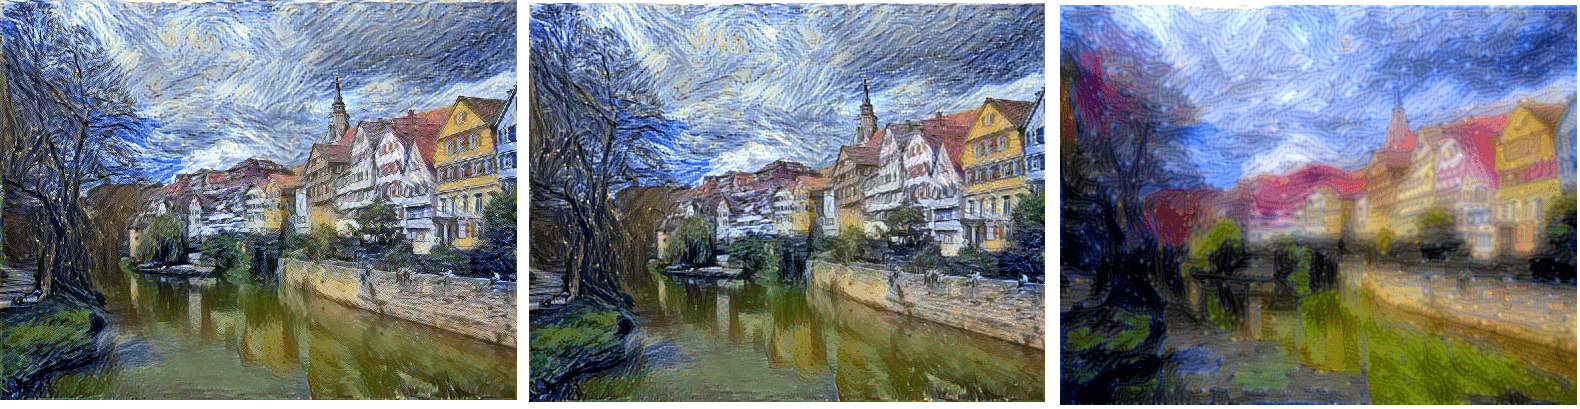

A diferencia del caso anterior en el cual se corrieron solo 15 iteraciones, en este caso se corrieron 100 y se aumentó por 1e6 el parámetro $\beta$ que controla cuanto de estilo queremos que exprese la imagen y dejamos el TV en 0.1 como estaba originalmente.

A la derecha se puede observar la imagen con más estilo y en la misma puede apreciarse como se van perdiendo algunos detalles del contenido para darle paso a un poco más de textura. Por ejemplo en la cúpula de la torre o en los ventanales de las casas.

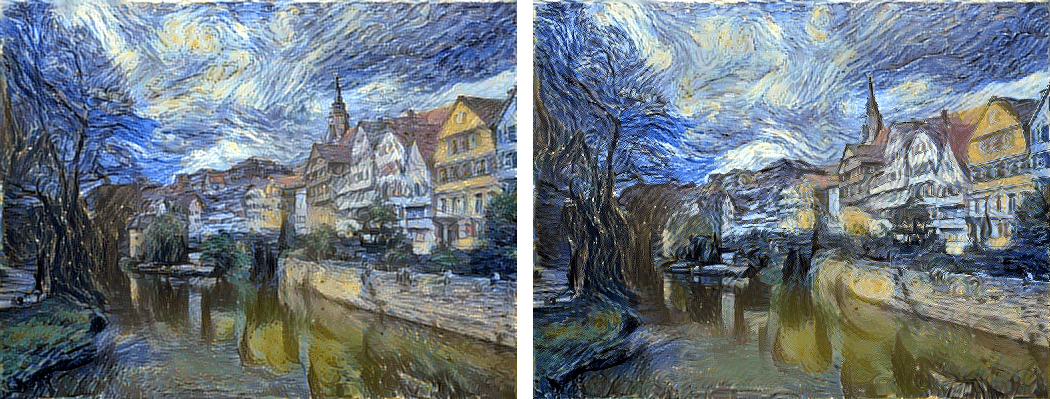

Finalmente, vamos a aumentar por 100 el parámetro $\alpha$ que controla cuanto de contenido queremos que exprese la imagen y dejamos el TV en 0.1 como estaba originalmente.

En este caso vemos una imagen más parecida al contenido base en cuanto a colores pero se ven rasgos de las pinceladas del estilo.

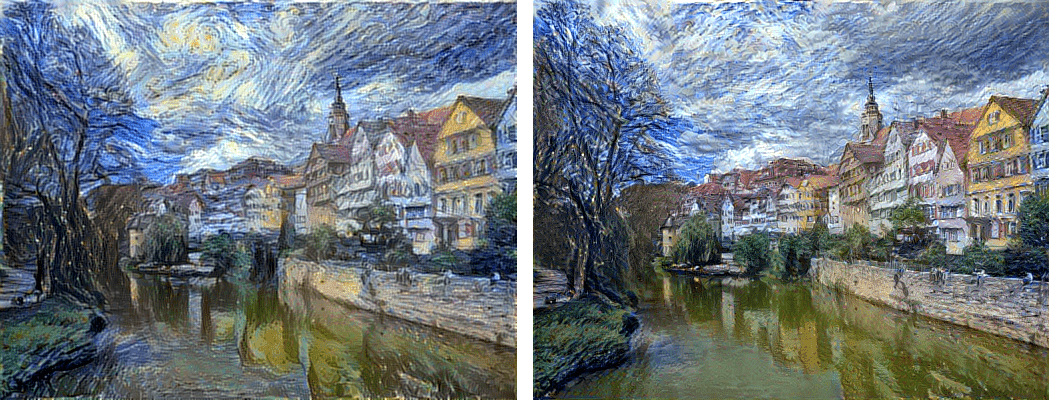

# 9) Cambiar las imágenes de contenido y estilo por unas elegidas por usted. Adjuntar el resultado.
Respuesta:

Como primer ejemplo de uso de style transfer se me ocurrió darle a una foto real el estilo de un auto retrato de Van Gogh para verificar si se respeta el estilo y considero que el resultado es adecuado.

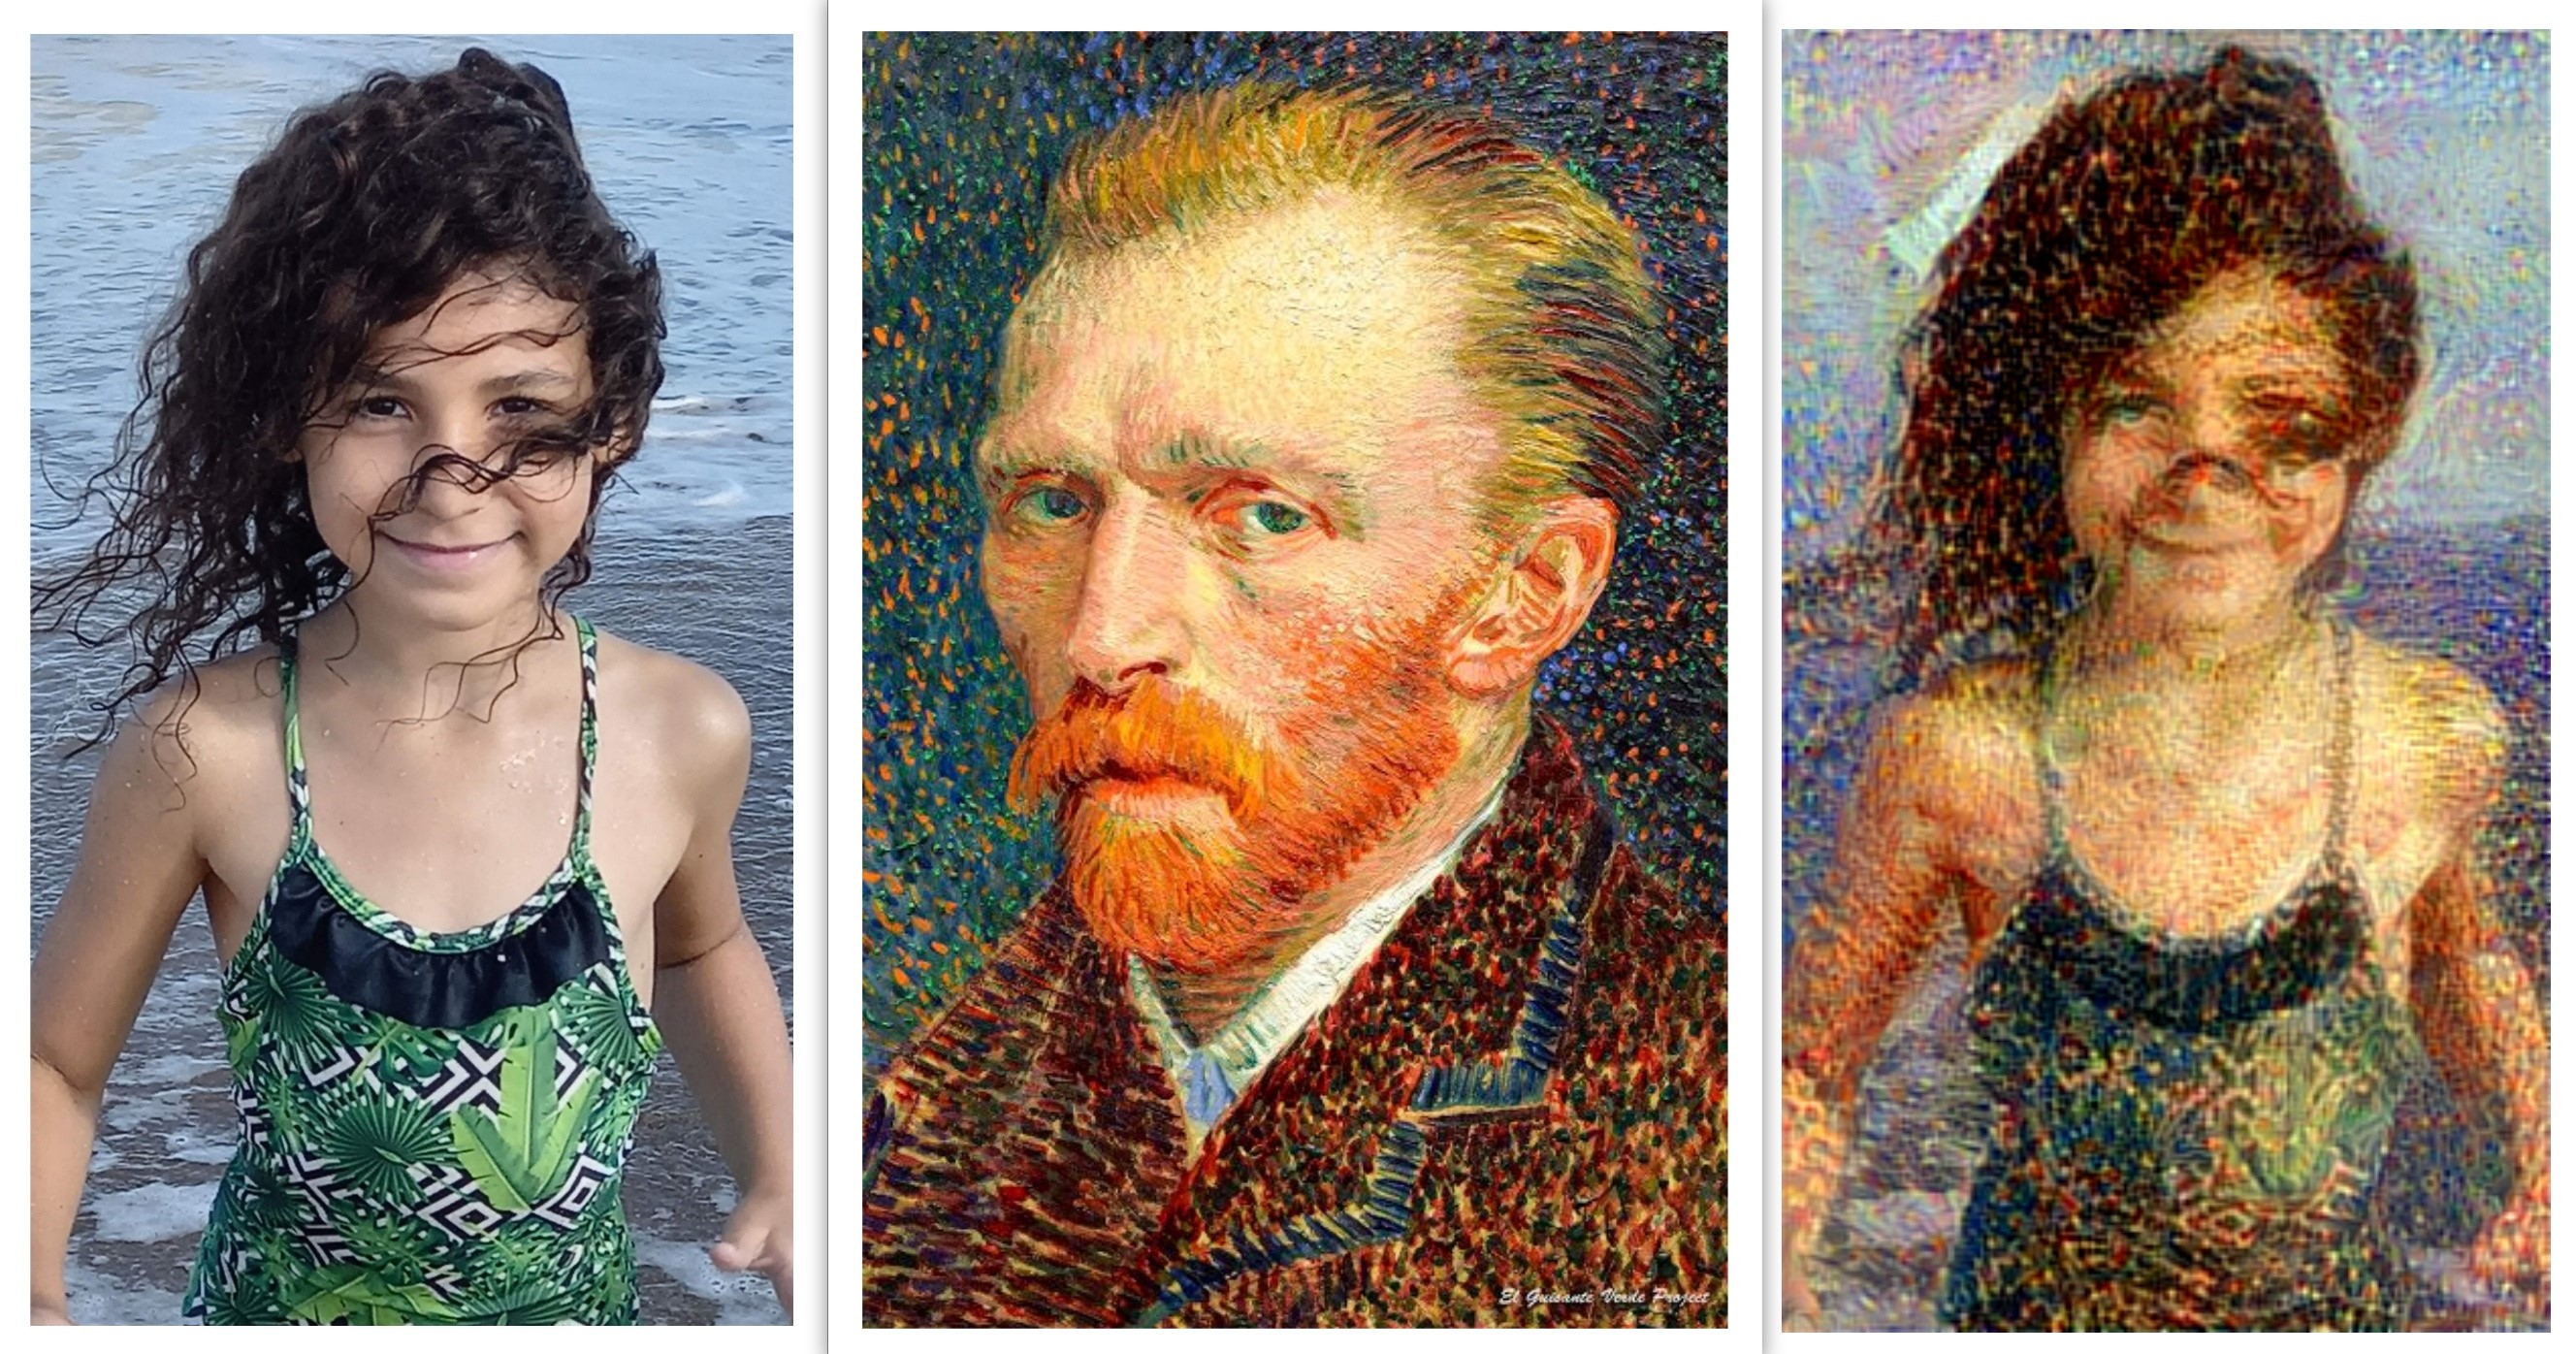

Una vez realizado lo mostrado en el punto anterior se me ocurrió probar el caso inverso. Qué pasaría si quisiéramos "humanizar" el autoretrato de Van Gogh? Y para ello tomé una foto de Lionel Messi en el que tiene una postura parecida a la original del pintor. 
El resultado es el que se visualiza abajo. Algo curioso es que la red mapeó el saco de Van Gogh con la barba de Messi quedando algo extraño.

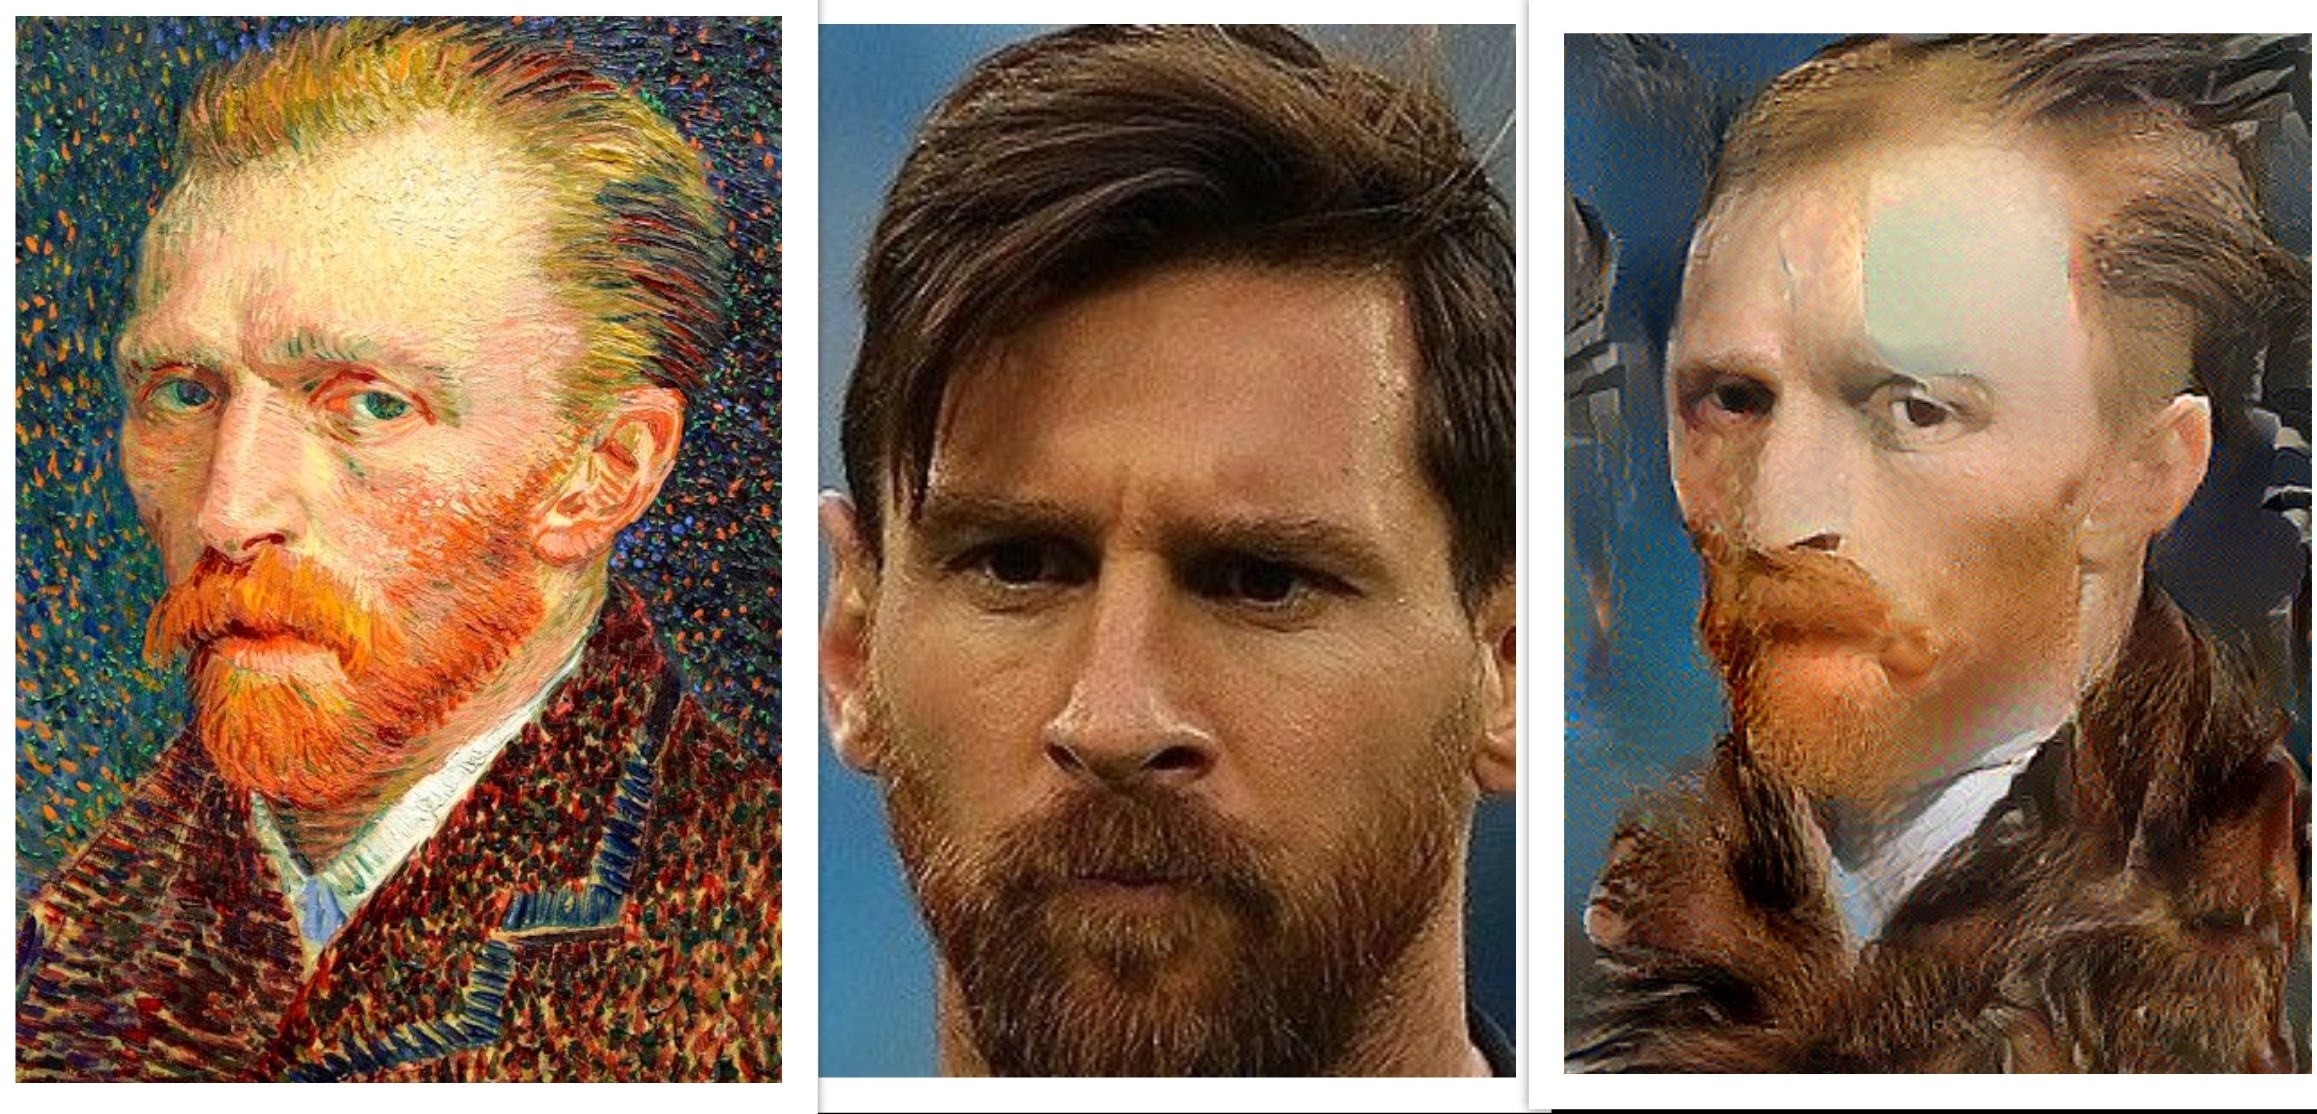

Para el siguiente ejemplo la idea era mezclar el contenido de Vermeer con un cuadro abstracto de Kandinski.

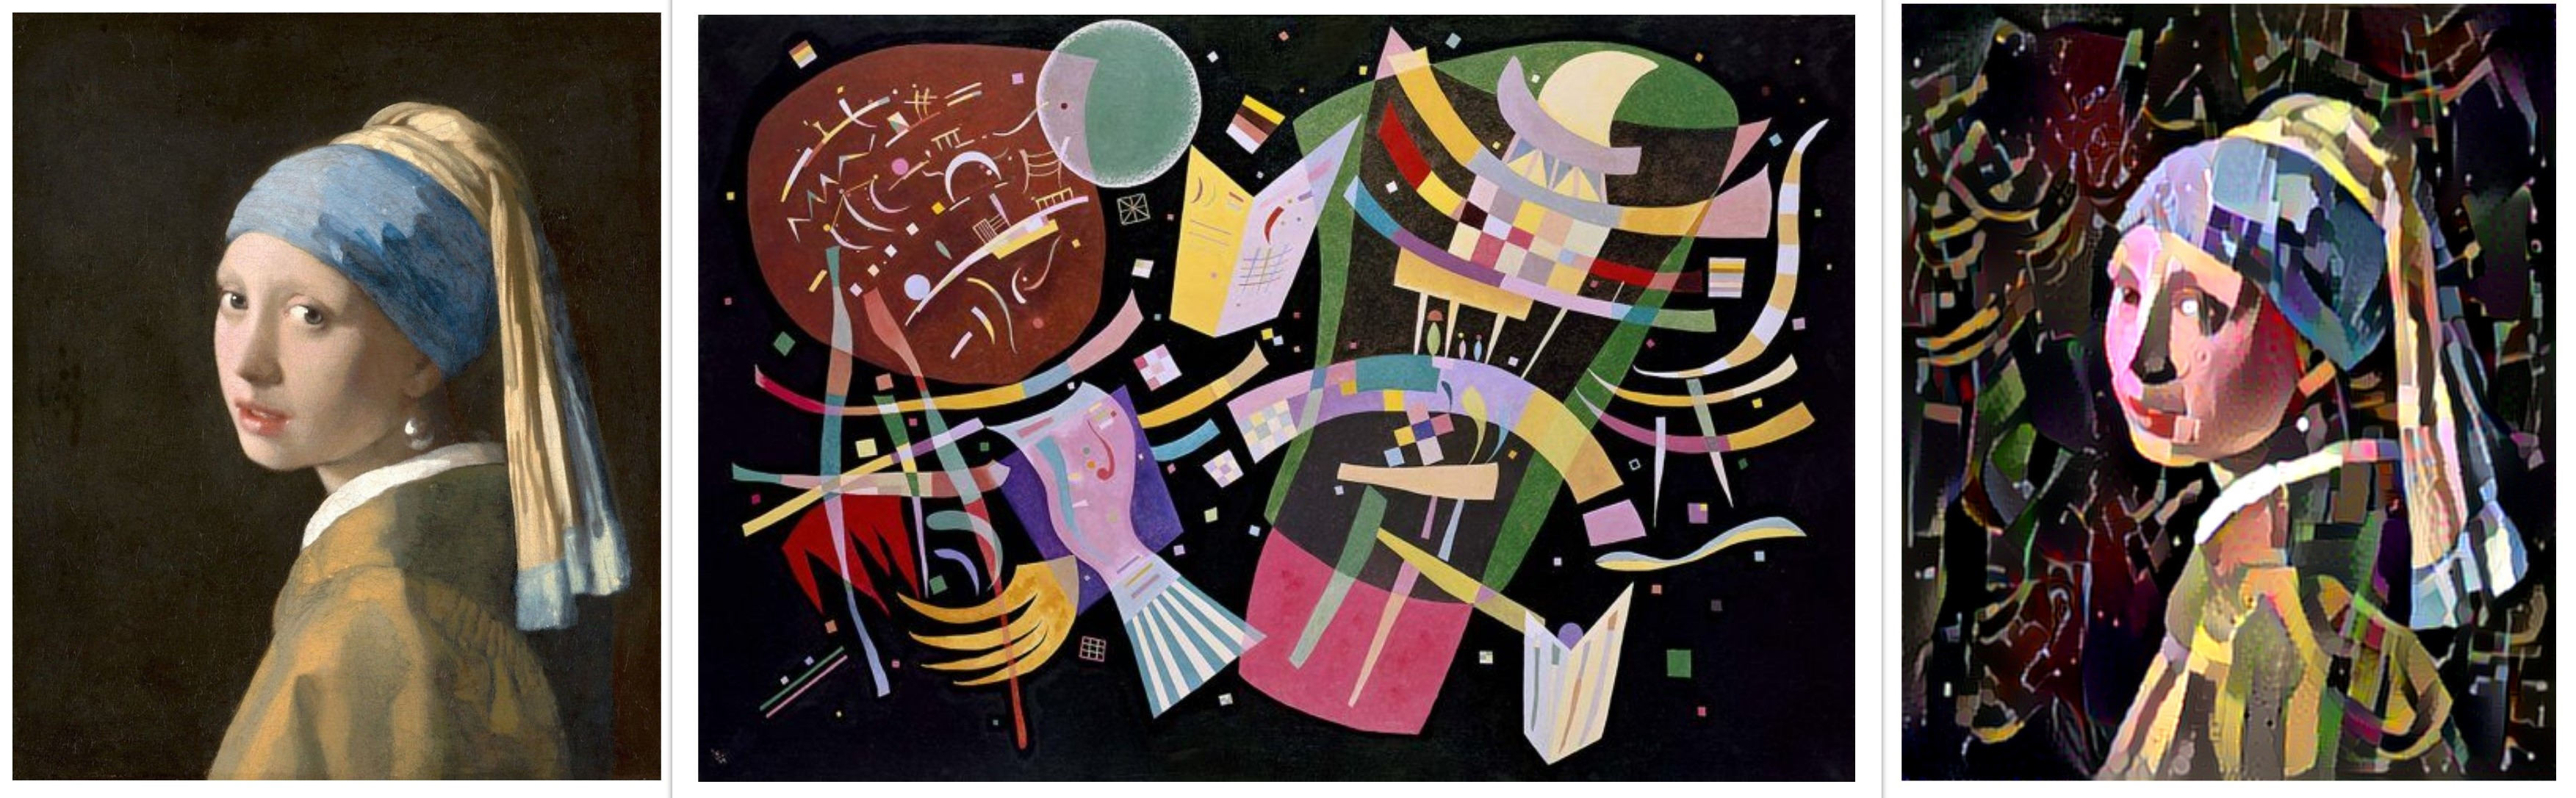

Otro ejemplo que va en ese sentido fue componer Vermeer con el cuadro "El beso" de Klimt.

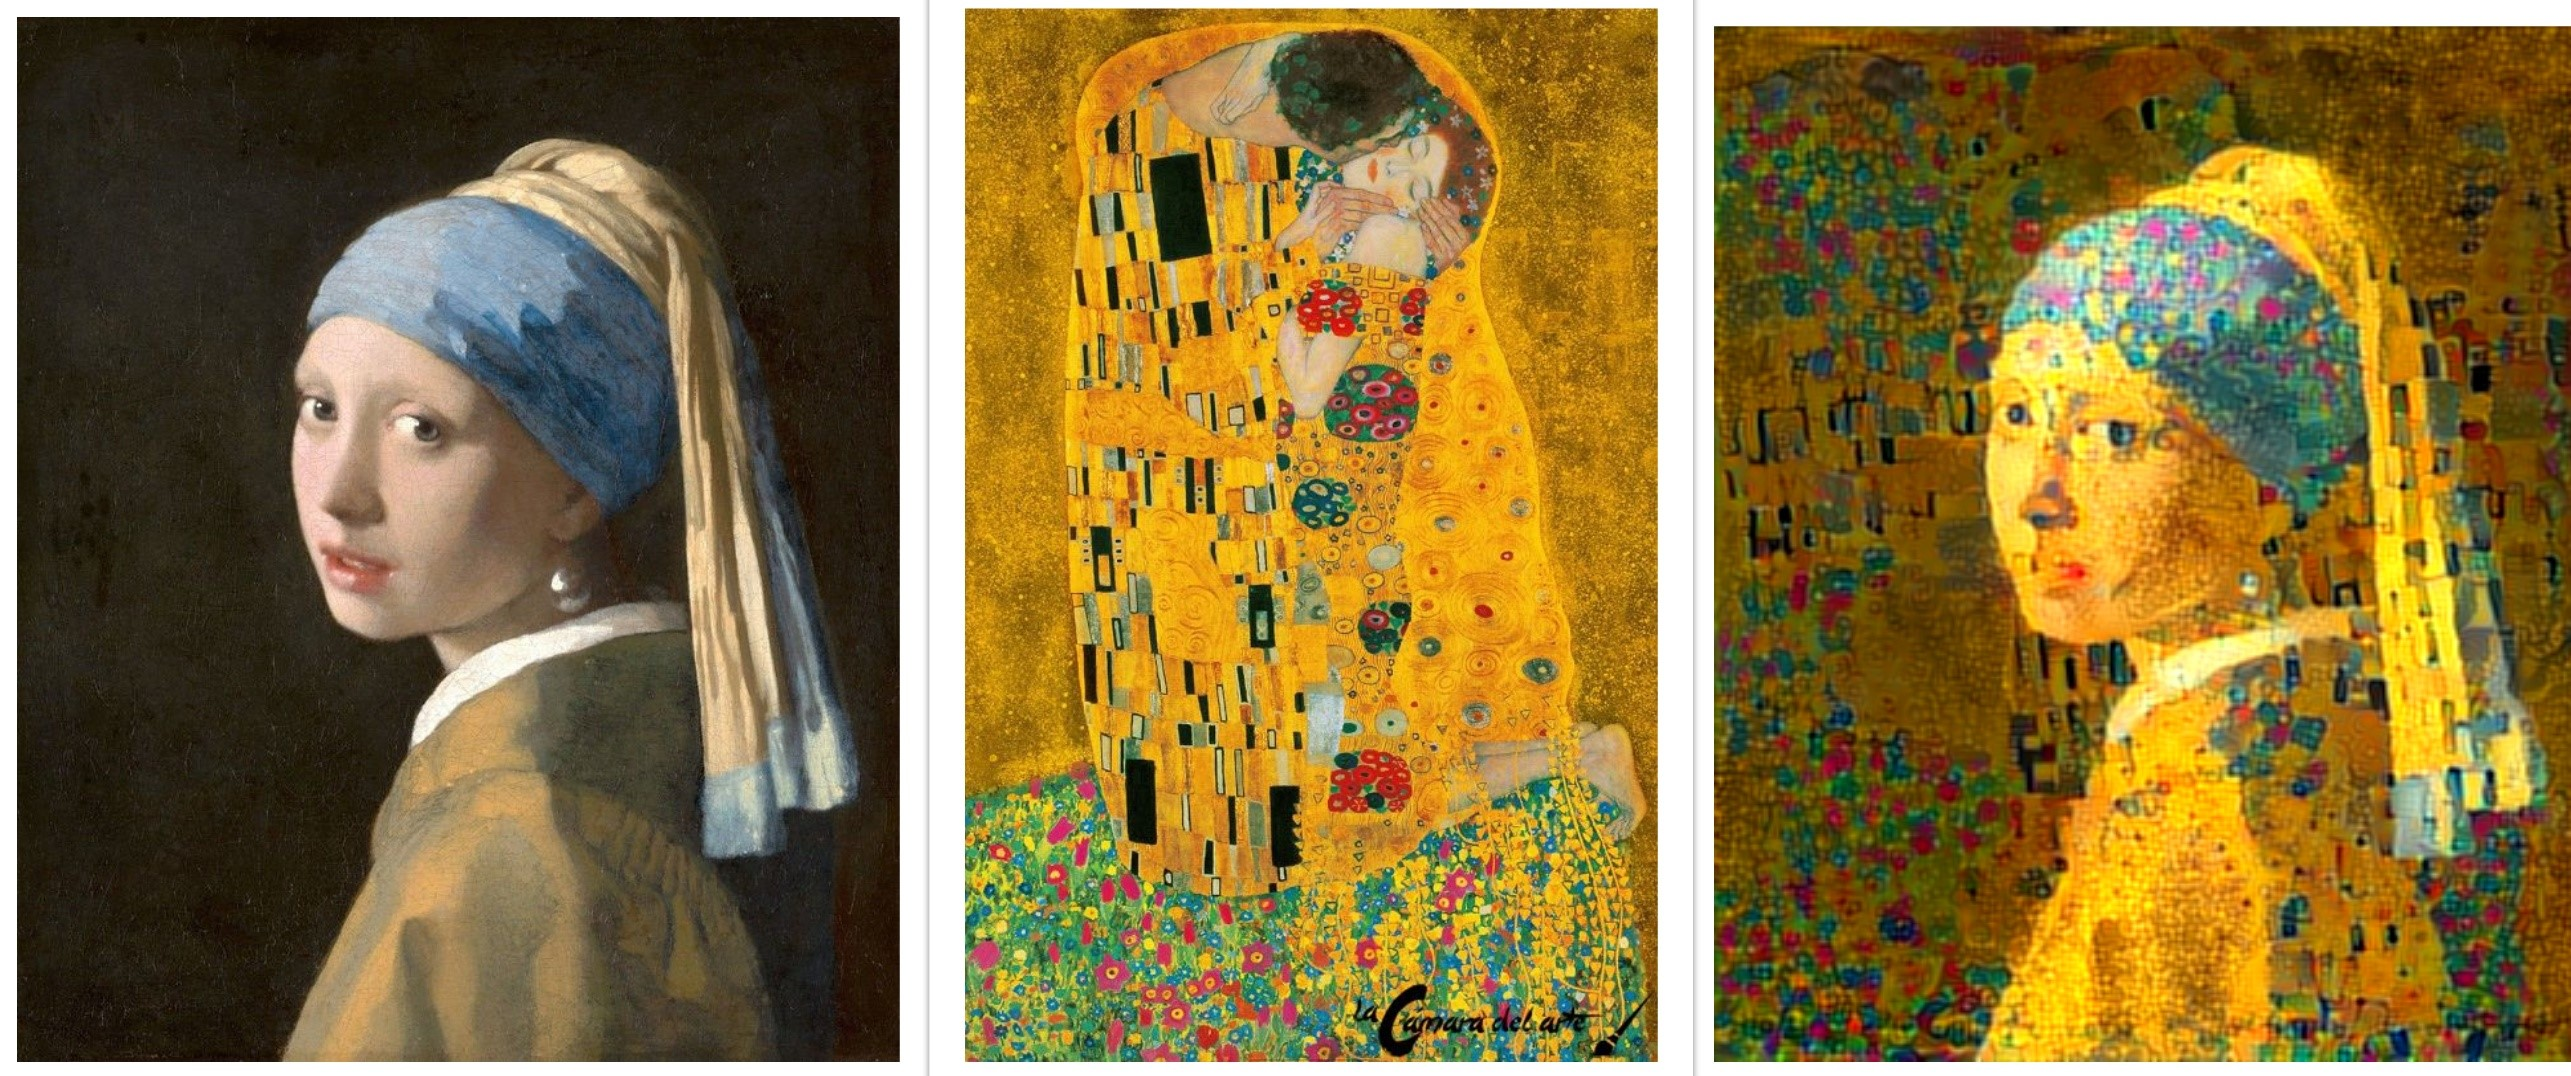